# Première exploration des données de télémétrie

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme("notebook")
%matplotlib inline

In [2]:
df = pd.read_csv("../data/raw/PdM_telemetry.csv")
df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [26]:
df.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [3]:
df["datetime"] = pd.to_datetime(df["datetime"])

### Division de la dataframe : une pour chaque machine

In [29]:
df_by_machine = df.groupby("machineID")
n_machines = df["machineID"].nunique()
dfs = [] # liste contenant tous les dataframes
for i in range(1,n_machines+1):
    dfs.append(df_by_machine.get_group(i))

### A-t-on des données manquantes ou incomplètes ?

Est-ce qu'il y a des trous dans le log de la télémétrie ?

In [42]:

print("Début des données : ", df.datetime.min())
print("Fin des données : ", df.datetime.max())
print("Durée des données télémétriques :", df.datetime.max()-df.datetime.min())
print("\n Nombre de valeurs uniques par colonnes :")
df.nunique()

Début des données :  2015-01-01 06:00:00
Fin des données :  2016-01-01 06:00:00
Durée des données télémétriques : 365 days 00:00:00

 Nombre de valeurs uniques par colonnes :


datetime       8761
machineID       100
volt         876100
rotate       876100
pressure     876100
vibration    876100
dtype: int64

In [45]:
df.count()

datetime     876100
machineID    876100
volt         876100
rotate       876100
pressure     876100
vibration    876100
dtype: int64

On a 100 machines et il y a 8760 heures dans une année donc pour chaque machine on a bien une entrée par heure. Pas de valeurs non renseignées non plus.

# Visualisation des données de télémétrie

Pour la machine 1 :

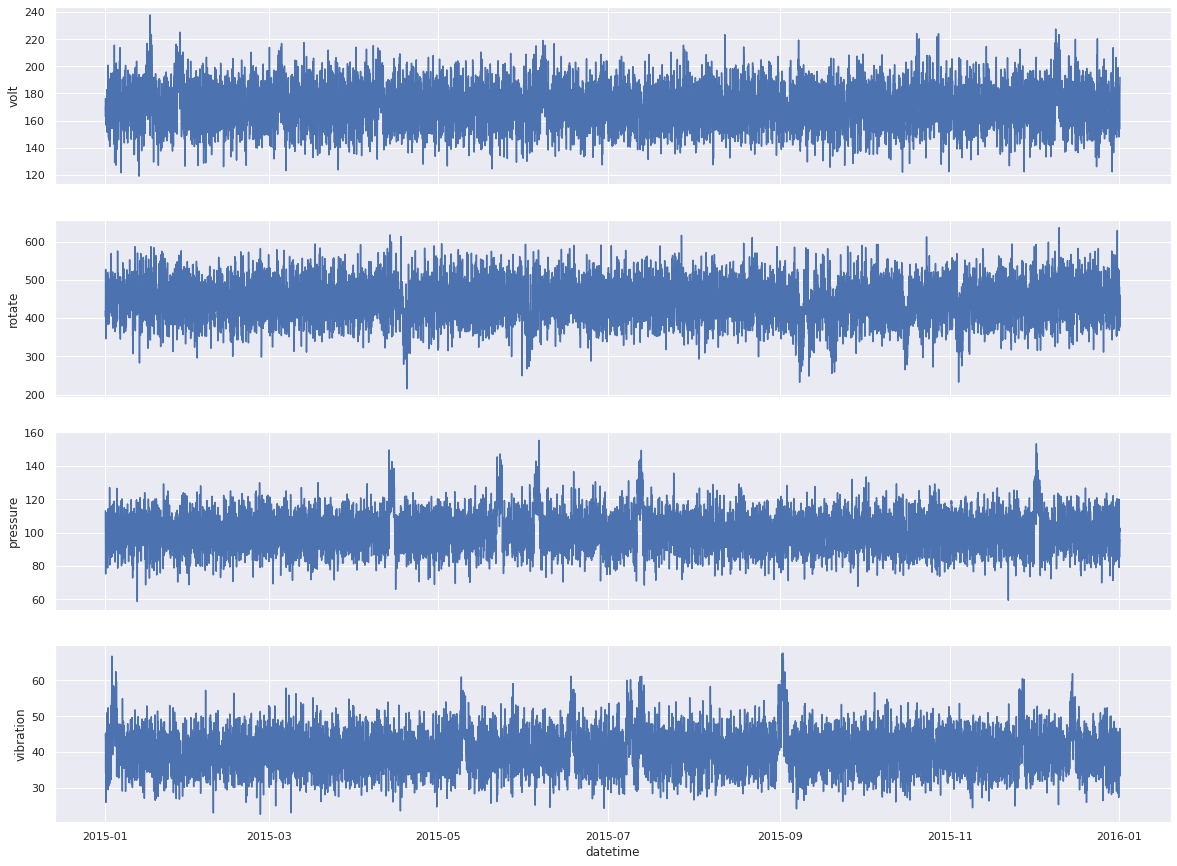

In [30]:
fig, axes = plt.subplots(4,1,sharex=True,figsize=(20,15))
quantities = ["volt","rotate","pressure","vibration"]
for i, ax, q in zip(range(5), axes,quantities):
    sns.lineplot(data=dfs[0],x="datetime",y=q,ax=axes[i])


Les valeurs de chaque capteur reste généralement autour d'une valeur moyenne mais parfois s'écartent brutalement. Est-ce que cela correspond à une erreur ou une défaillance ?

In [66]:
df_err = pd.read_csv("../data/raw/PdM_errors.csv")
df_fail = pd.read_csv("../data/raw/PdM_failures.csv")

df_err["datetime"] = pd.to_datetime(df_err["datetime"])
df_fail["datetime"] = pd.to_datetime(df_fail["datetime"])

# On restreint à la machine 1 qui nous intéresse ici
df_err = df_err.loc[df_err["machineID"] == 1]
df_fail = df_fail.loc[df_fail["machineID"]== 1]

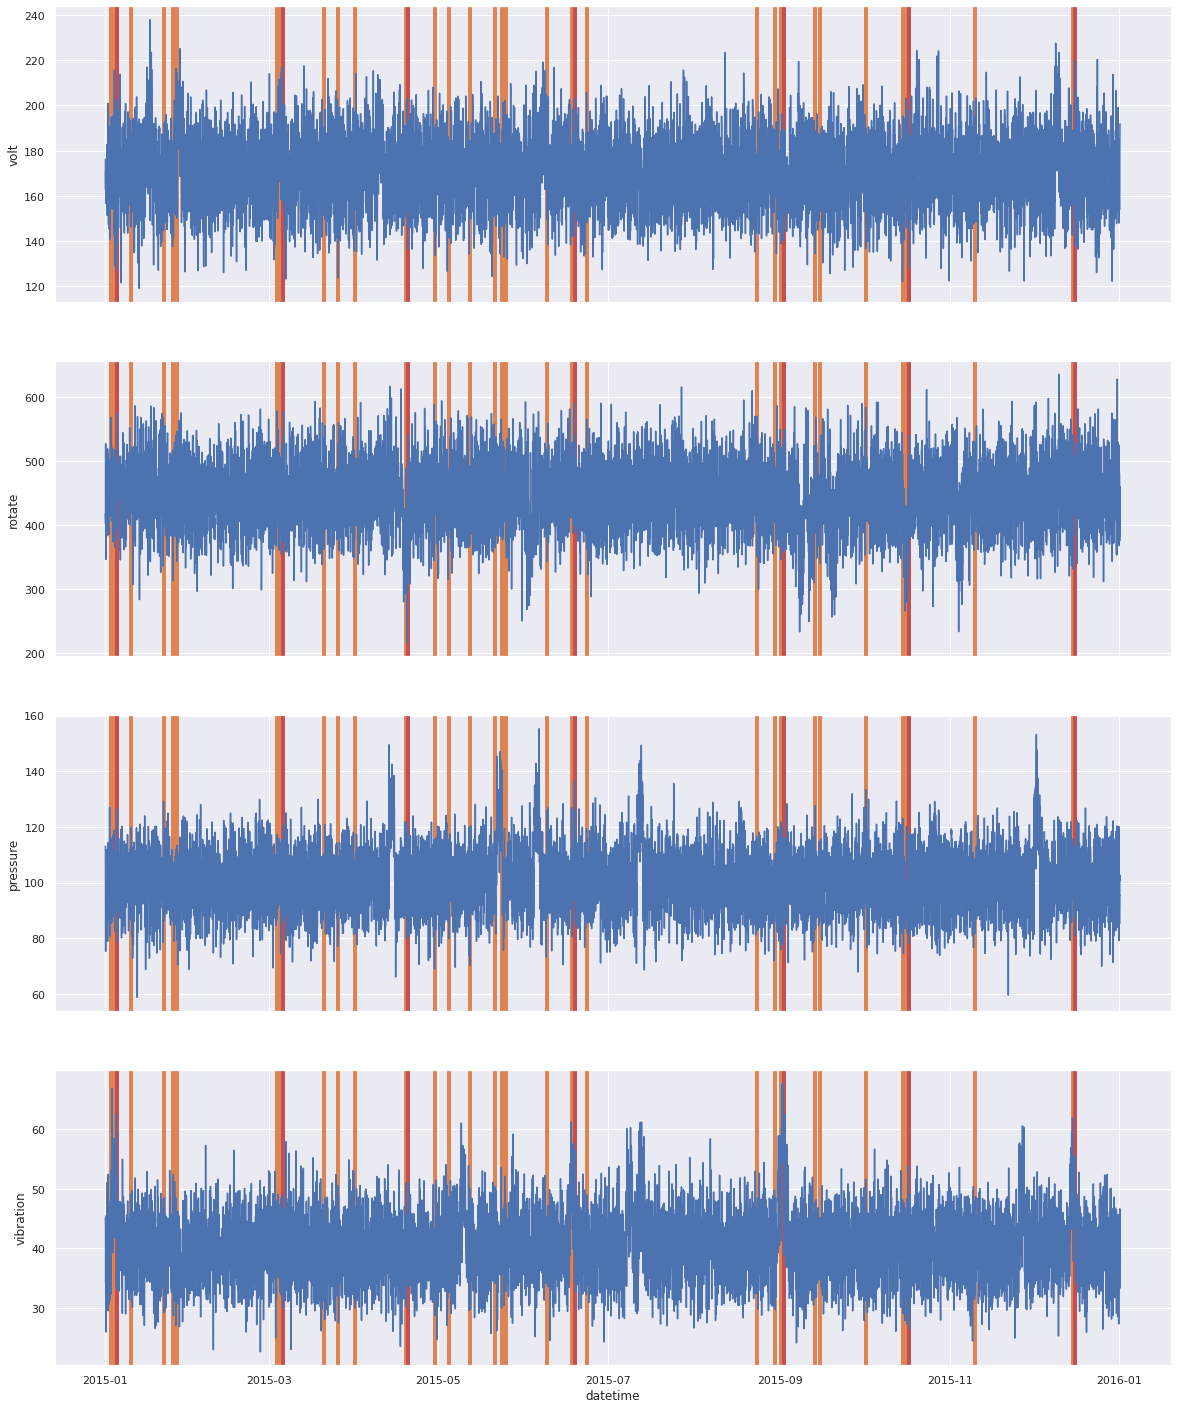

In [68]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(4,1,sharex=True,figsize=(20,25))
quantities = ["volt","rotate","pressure","vibration"]
for i, ax, q in zip(range(5), axes,quantities):
    for j in range(len(df_err)):
        axes[i].axvline(x=df_err["datetime"][j],c= cycle[1], lw=4)
    for k in range(len(df_fail)):
        axes[i].axvline(x=df_fail["datetime"][k], c = cycle[3],lw =4)
    sns.lineplot(data=dfs[0],x="datetime",y=q,ax=axes[i])

En orange les erreurs et en rouge les défaillances.

Les défaillances correspondent quasiment tout le temps avec un écart (pic ou creux) d'une des quantités télémétriques par rapport à sa valeur moyenne. Ce n'est pas forcément le cas pour les erreurs qui peuvent arriver quand il n'y a rien de spécifique dans la télémétrie. On notera aussi qu'un écart à la valeur moyenne n'implique pas toujours de défaillance (par exemple voir mi/fin juillet).